In [1]:
import torch
import numpy as np
from abcpy.output import Journal
import matplotlib.pyplot as plt
import pickle
from src.models.lorenz_96_model import Lorenz96SDE
from src.models.neural_lorenz_96_model import NeuralLorenz96SDE
from src.scoring_rules.scoring_rules import EnergyScore
from jax import jit, random
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from abcpy.continuousmodels import ProbabilisticModel, Continuous, InputConnector, Uniform, Normal
from abcpy.statistics import Statistics, Identity
import pickle
import functools
from einops import rearrange
from src.utils import transform_neural_lorenz_parameter
import matplotlib as mpl
import scipy.stats as st

/home/minny/anaconda3/envs/GBLFI-final/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_list = (0,1,2,3,4)

neurals = []
linears = []
obs_list = []
init_val_list = []

for i in exp_list:
    obs_path = f'./obs/lorenz96_obs_{i}.pty'
    init_obs_path = f'./obs/lorenz96_obs_initial{i}.pty'

    with open(f'sgnht_l96_{i}.pickle', 'rb') as handle:
        linears.append(pickle.load(handle))

    with open(f'nl96_{i}.pickle', 'rb') as handle:
        neurals.append(pickle.load(handle))

    obs_list.append(torch.load(obs_path))
    init_val_list.append(torch.load(init_obs_path))

norm_obs_list = []
for idx, obs in enumerate(obs_list):
    norm_obs = rearrange(obs, 't d -> t 1 d')
    norm_obs = (norm_obs - init_val_list[idx].mean()) / init_val_list[idx].std()
    norm_obs = rearrange(norm_obs, 't 1 d -> 1 (t d)')
    norm_obs_list.append(norm_obs)


In [3]:
for linear in linears:
    trans = linear['config']['transformer']
    linear['samples_con'] = trans.inverse_transform(linear['samples_uncon'], use_torch=True)

In [4]:
from sgmcmcjax.ksd import imq_KSD

x_neural = list(range(1000,21000,1000))
y_neural = []
for i in tqdm(x_neural):
    y_neural.append(imq_KSD(neurals[0]['samples_uncon'][:i].numpy(), neurals[0]['samples_grad'][:i].numpy()).item())

100%|██████████| 20/20 [48:47<00:00, 146.35s/it]


In [5]:
x_stoch = list(range(1000,21000,1000))
y_stoch = []
for i in tqdm(x_stoch):
    y_stoch.append(imq_KSD(linears[0]['samples_uncon'][:i].numpy(), linears[0]['samples_grad'][:i].numpy()).item())

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


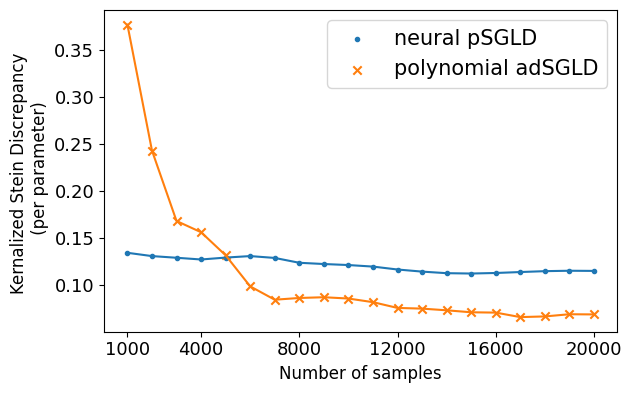

In [6]:
params = {
   'text.usetex': False,
   'figure.figsize': [6.4, 4],
    'font.size': 9,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'legend.fontsize': 15,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
   }

with mpl.rc_context(params):
    #color = "0"
    fig, ax = plt.subplots(figsize=(6.4,4))



    plt.scatter(x_neural, [item/111 for item in y_neural[:20]], marker='.', label='neural pSGLD')
    plt.plot(x_neural, [item/111 for item in y_neural])
    plt.scatter(x_stoch,[item/3 for item in y_stoch], marker='x', label='polynomial adSGLD')
    plt.plot(x_stoch,[item/3 for item in y_stoch])

    plt.legend(loc='upper right')
    plt.xlabel('Number of samples')
    ax.set_xticks(np.append(1000, np.arange(4000,21000,4000)))
    plt.ylabel('Kernalized Stein Discrepancy \n (per parameter)') 
    fig.tight_layout()#rect=[0.2,0.2,.2,.2]) 
    plt.savefig("KSD Convergence Between polynomial adSGLD and neural pSGLD.pdf", bbox_inches='tight')


In [7]:
# These intermediate simulation files are saved in the `simulation_for_metrics` folder
# linear_sims = []
# neural_sims = []

# for exp_idx, exp_num in enumerate(exp_list):
#     sgnht_sims = []
#     nl96_sims = []

#     l96 = Lorenz96SDE(y0=init_val_list[exp_idx])
#     nl96 = NeuralLorenz96SDE(y0=init_val_list[exp_idx])
#     ntrans = neurals[exp_idx]['config']['transformer']

#     for i in tqdm(range(1,1001)):
#         sims = l96.torch_forward_simulate(linears[exp_idx]['samples_con'][-i,:], 500)
#         sgnht_sims.append(sims.detach())

#         nparam_torch_unconstrained = neurals[exp_idx]['samples_uncon'][-i,:].float()
#         nparam_torch_unconstrained = transform_neural_lorenz_parameter(nparam_torch_unconstrained)
#         nparam_torch_constrained = [ntrans.inverse_transform(nparam_torch_unconstrained[0], use_torch=True).float(), nparam_torch_unconstrained[1]]
#         nsims = nl96.torch_forward_simulate(nparam_torch_constrained, 500)
#         nl96_sims.append(nsims.detach())

#     linear_sims.append(sgnht_sims)
#     neural_sims.append(nl96_sims)

# all_sgnht_scores = []
# all_psgld_scores = []
# es = EnergyScore(weight=1)

# for idx, _ in enumerate(linear_sims):
#     total_sgnht_scores = []
#     #20 * 8 = 160
#     for sim in linear_sims[idx]:
#         scores = [] #20 scores for each timestep
#         for i in range(0,160,8): #0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,136,144,152
#             scores.append(es.score(observations = norm_obs_list[idx][:,i:i+8], simulations = sim[:,i:i+8], use_torch=True))
#         total_sgnht_scores.append(scores) #1000 scores in total

#     total_psgld_scores = []
#     #20 * 8 = 160
#     for sim in neural_sims[idx]:
#         scores = [] #20 scores for each timestep
#         for i in range(0,160,8): #0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,136,144,152
#             scores.append(es.score(observations = norm_obs_list[idx][:,i:i+8], simulations = sim[:,i:i+8], use_torch=True))
#         total_psgld_scores.append(scores) #1000 scores in total


#     all_sgnht_scores.append(total_sgnht_scores)
#     all_psgld_scores.append(total_psgld_scores)

In [9]:
with open('simulations_for_metrics/all_sgnht_scores.pickle', 'rb') as handle:
    all_sgnht_scores = pickle.load( handle)

with open('simulations_for_metrics/all_psgld_scores.pickle', 'rb') as handle:
    all_psgld_scores = pickle.load( handle)

In [10]:
# We average over the sims to get the average posterior predictive score
# np.array(all_sgnht_scores) : (5,1000,20) # Dataset, sims, ts
# np.array(all_abc_scores) : (5,1000,20)
ts = np.arange(1,21)
mean_sg_scores = np.array(all_sgnht_scores).mean(axis=1) # (5,20)
mean_psgld_scores = np.array(all_psgld_scores).mean(axis=1)

# From mean_sg_scores : (5,20)
# To ci_sg_scores : (20,3)
ci_sg_scores = []
ci_psgld_scores = []
for i in range(20):
    #ci_sg = st.norm.interval(0.95, loc=np.mean(mean_sg_scores[:,i]), scale=st.sem(mean_sg_scores[:,i]))
    ci_sg = st.t.interval(0.95, df=len(mean_sg_scores[:,i])-1, loc=np.mean(mean_sg_scores[:,i]), scale=st.sem(mean_sg_scores[:,i]))
    #ci_psgld = st.norm.interval(0.95, loc=np.mean(mean_psgld_scores[:,i]), scale=st.sem(mean_psgld_scores[:,i]))
    ci_psgld = st.t.interval(0.95, df=len(mean_psgld_scores[:,i])-1, loc=np.mean(mean_psgld_scores[:,i]), scale=st.sem(mean_psgld_scores[:,i]))
    ci_sg_scores.append((np.mean(mean_sg_scores[:,i]), ci_sg[0], ci_sg[1]))
    ci_psgld_scores.append((np.mean(mean_psgld_scores[:,i]), ci_psgld[0], ci_psgld[1]))

ci_sg_scores = np.array(ci_sg_scores)
ci_psgld_scores = np.array(ci_psgld_scores)

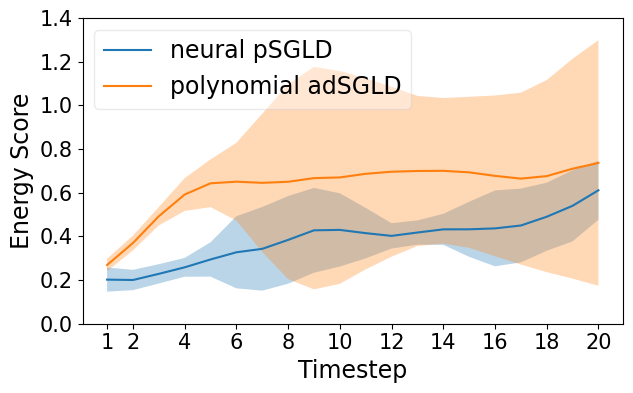

In [11]:
params = {
   'text.usetex': False,
   'figure.figsize': [6.4, 4],
    'font.size': 9,
    'axes.labelsize': 17,
    'axes.titlesize': 12,
    'legend.fontsize': 17,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
   }


with mpl.rc_context(params):
    fig, ax = plt.subplots(figsize=(6.4,4))

    plt.plot(ts,ci_psgld_scores[:,0], label='neural pSGLD')#, ls='-.')
    plt.fill_between(ts, (ci_psgld_scores[:,2]), (ci_psgld_scores[:,1]), alpha=.3)
    plt.plot(ts,ci_sg_scores[:,0], label='polynomial adSGLD')
    plt.fill_between(ts, (ci_sg_scores[:,2]), (ci_sg_scores[:,1]), alpha=.3)

    plt.legend(loc='upper left',framealpha=0.4)
    plt.xlabel('Timestep')
    ax.set_xticks(np.append(1,np.arange(2,21,2)))
    plt.ylabel('Energy Score') 
    ax.set_ylim(bottom=0.0,top=1.4)
    ax.set_yticks(np.arange(0.,1.5,0.2))
    fig.tight_layout() 
    plt.plot()
    plt.savefig("Posterior predictive pSGLD adSGLD.pdf")#, bbox_inches='tight')